<a href="https://colab.research.google.com/github/ethngo7/poker-cv-project/blob/main/end_to_end_pipeline_(poker_cv_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
from google.colab import files
files.upload()

# upload kaggle dataset zip
# upload best.pt from runs3...
# upload card_classifier.pt

{}

In [112]:
# kaggle - cards image dataset - kaggle.zip

import zipfile
import os

with zipfile.ZipFile("kaggle - cards image dataset - kaggle.zip", 'r') as zip_ref:
    zip_ref.extractall("kaggle_individual_cards")


In [97]:
# Confirm contents
nums_suits = os.listdir("kaggle_individual_cards/train")
nums_suits

['two of spades',
 'six of diamonds',
 'four of diamonds',
 'eight of diamonds',
 'seven of spades',
 'four of hearts',
 'four of spades',
 'jack of hearts',
 'king of clubs',
 'nine of spades',
 'five of diamonds',
 'seven of hearts',
 'three of spades',
 'ace of clubs',
 'six of hearts',
 'queen of spades',
 'eight of clubs',
 'five of clubs',
 'queen of hearts',
 'jack of diamonds',
 'five of hearts',
 'ace of spades',
 'eight of spades',
 'king of diamonds',
 'jack of clubs',
 'nine of diamonds',
 'two of hearts',
 'four of clubs',
 'joker',
 'king of spades',
 'nine of clubs',
 'three of clubs',
 'nine of hearts',
 'ten of clubs',
 'ten of spades',
 'eight of hearts',
 'three of diamonds',
 'three of hearts',
 'ten of diamonds',
 'two of clubs',
 'seven of clubs',
 'seven of diamonds',
 'queen of diamonds',
 'six of spades',
 'jack of spades',
 'queen of clubs',
 'ace of diamonds',
 'ace of hearts',
 'six of clubs',
 'five of spades',
 'ten of hearts',
 'two of diamonds',
 'king o

In [18]:
!pip install ultralytics

In [43]:
from ultralytics import YOLO
import torch
from torchvision import models

detector = YOLO("best.pt") # from runs3

classifier = models.resnet18()
classifier.fc = torch.nn.Linear(classifier.fc.in_features, 53)
classifier.load_state_dict(torch.load("card_classifier.pt"))
classifier.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
img_name = "/content/Screenshot-2025-07-07-at-17_06_20_png.rf.10378192e08c344ee5a2bfa3025c0ddc.jpg"
results = detector(img_name)

boxes = results[0].boxes.xyxy.cpu().numpy() # converting to cpu necessary for converting to numpy. needed for compatibility across other libraries
confs = results[0].boxes.conf.cpu().numpy()


image 1/1 /content/Screenshot-2025-07-07-at-17_06_20_png.rf.10378192e08c344ee5a2bfa3025c0ddc.jpg: 256x640 4 community_cards, 146.2ms
Speed: 2.5ms preprocess, 146.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


In [88]:
import numpy as np
from PIL import Image

# Load original image
orig_img = Image.open(img_name).convert("RGB") # converts image to red-green-blue format
W, H = orig_img.size
print(f"Image Dimensions: {W, H}")

# Sort boxes by confidence
order = confs.argsort()[::-1]
boxes = boxes[order]
confs = confs[order]

# Get top 5 in the same row (like before)
row_tol = 0.18 * H # 18% of image height helps determine which cards are "on the same row"
kept_boxes = []
base_y = None

for box in boxes:
    x1, y1, x2, y2 = box
    yc = (y1 + y2) / 2
    if base_y is None or abs(yc - base_y) < row_tol:
        base_y = yc if base_y is None else base_y
        kept_boxes.append([int(x1), int(y1), int(x2), int(y2)])
    if len(kept_boxes) == 5:
        break



Image Dimensions: (574, 228)


Card 1: nine of hearts
Card 2: ace of hearts
Card 3: four of hearts
Card 4: nine of diamonds


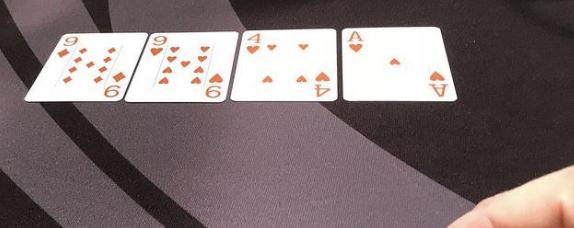

In [89]:
from torchvision import transforms
import torch
import os

# Define same transform used in training
tfm = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

# Load classifier model
from torchvision import models
classifier = models.resnet18()
classifier.fc = torch.nn.Linear(classifier.fc.in_features, 53)
classifier.load_state_dict(torch.load("card_classifier.pt"))
classifier.eval()

# Get class names from training dataset (if available)
# OR manually define class_labels = ['2 of clubs', '3 of diamonds', ...]
class_labels = sorted(os.listdir("kaggle_individual_cards/train"))  # adjust path

# Run classification
for i, (x1, y1, x2, y2) in enumerate(kept_boxes):
    card_crop = orig_img.crop((x1, y1, x2, y2))
    input_tensor = tfm(card_crop).unsqueeze(0)
    with torch.no_grad():
        output = classifier(input_tensor)
        pred_class = output.argmax(dim=1).item()
        label = class_labels[pred_class]
        print(f"Card {i+1}: {label}")

Image.open(img_name)

In [112]:
# @title User Input


while True:
    hole_cards = input("Enter your hole cards (e.g. nine of clubs, ace of diamonds): ")

    # Normalize common patterns and split
    cleaned = hole_cards.lower().replace(" and ", ",").replace("  ", " ").strip()
    cards = [card.strip() for card in cleaned.split(",") if card.strip()]

    if len(cards) != 2:
        print("Please enter exactly two cards, separated by comma or 'and'.\n")
        continue

    # Check if both cards exactly match the labels
    if all(card in nums_suits for card in cards):
        break
    else:
        print("One or both cards are invalid. Please make sure your spelling and casing match exactly.\n")

print(f"Hole cards accepted: {cards[0]}, {cards[1]}")

Enter your hole cards (e.g. nine of clubs, ace of diamonds): king of spades, queen of diamonds
Hole cards accepted: king of spades, queen of diamonds
